### Long short-term memory (LSTM) layer
- LSTM
    - LSTM is a type of recurrent neural network capable of learning order dependence in sequence prediction problems.
    - The two technical problems overcome by LSTMs are vanishing gradients and exploding gradients, both related to how the network is trained.
- Bidirectional RNN
    - It involves duplicating the first recurrent layer so that there are now two layers side-by-side, then providing the input sequence as-is as input to the first layer and providing a reversed copy of the input sequence to the second. Timesteps in the input sequence are still processed one at a time, it is just the network steps through the input sequence in both directions at the same time.
    - It also allows you to specify the merge mode, that is how the forward and backward outputs should be combined before being passed on to the next layer. The options are:
        - ‘sum‘: The outputs are added together.
        - ‘mul‘: The outputs are multiplied together.
        - ‘concat‘: The outputs are concatenated together (the default), providing double the number of outputs to the next layer. Default.
        - ‘ave‘: The average of the outputs is taken.
    - It lets the LSTM learn faster

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
!pip install tf-nightly-2.0-preview


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.3.1


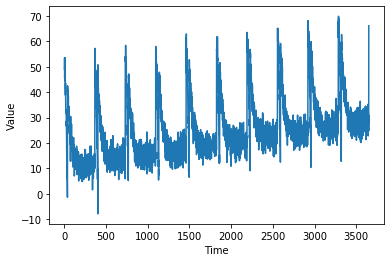

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(10 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
amplitude = 40
slope = 0.005
noise_level = 3

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=51)

split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

plot_series(time, series)

In [5]:
A = [1,2,3,4,5,6]
A[:-1]

[1, 2, 3, 4, 5]

In [3]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))# use every element befor the last one to predict the last one
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [6]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),   # 1 LSTM layer with 32 units
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),                          # 2 LSTM layer with 32 units
  tf.keras.layers.Dense(1),                                                         # final layer with 1 unit of result
  tf.keras.layers.Lambda(lambda x: x * 10.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(          # callbacks to use different learning rate and pick the best
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),             # Huber loss function, robust, less sensitive to outliers than MSE
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])   # trial to find best learning rate

Epoch 1/100
94/94 [==============================] - 9s 91ms/step - loss: 20.3828 - mae: 20.8828
Epoch 2/100
94/94 [==============================] - 7s 69ms/step - loss: 20.3543 - mae: 20.8543
Epoch 3/100
94/94 [==============================] - 6s 66ms/step - loss: 20.3218 - mae: 20.8218
Epoch 4/100
94/94 [==============================] - 10s 111ms/step - loss: 20.2852 - mae: 20.7851
Epoch 5/100
94/94 [==============================] - 12s 125ms/step - loss: 20.2436 - mae: 20.7436
Epoch 6/100
94/94 [==============================] - 11s 112ms/step - loss: 20.1964 - mae: 20.6964
Epoch 7/100
94/94 [==============================] - 10s 106ms/step - loss: 20.1429 - mae: 20.64291s - loss: 19.8675 
Epoch 8/100
94/94 [==============================] - 9s 99ms/step - loss: 20.0823 - mae: 20.5823
Epoch 9/100
94/94 [==============================] - ETA: 0s - loss: 20.0140 - mae: 20.514 - 9s 98ms/step - loss: 20.0140 - mae: 20.5140
Epoch 10/100
94/94 [==============================] - 7s 75m

94/94 [==============================] - 11s 115ms/step - loss: 3.6257 - mae: 4.0897
Epoch 77/100
94/94 [==============================] - 10s 110ms/step - loss: 3.5056 - mae: 3.9722
Epoch 78/100
94/94 [==============================] - 11s 117ms/step - loss: 3.3577 - mae: 3.82161s - loss: 3.324
Epoch 79/100
94/94 [==============================] - 11s 112ms/step - loss: 3.2502 - mae: 3.71453s - lo - ETA: 0s - loss: 3.2500 - mae
Epoch 80/100
94/94 [==============================] - 11s 121ms/step - loss: 3.3185 - mae: 3.78262s - loss: 3.2
Epoch 81/100
94/94 [==============================] - 10s 109ms/step - loss: 3.0720 - mae: 3.5357
Epoch 82/100
94/94 [==============================] - 11s 114ms/step - loss: 3.0517 - mae: 3.5155
Epoch 83/100
94/94 [==============================] - 11s 116ms/step - loss: 3.0879 - mae: 3.5528
Epoch 84/100
94/94 [==============================] - 10s 111ms/step - loss: 3.0458 - mae: 3.5115
Epoch 85/100
94/94 [==============================] - 11s 120ms

[1e-08, 0.0001, 0, 30]

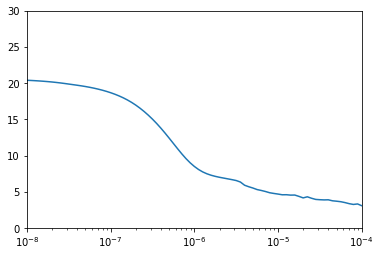

In [7]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9),metrics=["mae"])
history = model.fit(dataset,epochs=500,verbose=1)

Epoch 1/500
94/94 [==============================] - 7s 71ms/step - loss: 263.1986 - mae: 10.1378
Epoch 2/500
94/94 [==============================] - 12s 128ms/step - loss: 33.6153 - mae: 3.9017
Epoch 3/500
94/94 [==============================] - 10s 105ms/step - loss: 27.7103 - mae: 3.5518
Epoch 4/500
94/94 [==============================] - 11s 119ms/step - loss: 31.9159 - mae: 3.9759
Epoch 5/500
94/94 [==============================] - 10s 106ms/step - loss: 27.1127 - mae: 3.5515
Epoch 6/500
94/94 [==============================] - 10s 103ms/step - loss: 25.7764 - mae: 3.4461
Epoch 7/500
94/94 [==============================] - 10s 111ms/step - loss: 32.1397 - mae: 3.9959
Epoch 8/500
94/94 [==============================] - 10s 107ms/step - loss: 27.8369 - mae: 3.6121
Epoch 9/500
94/94 [==============================] - 13s 136ms/step - loss: 29.2938 - mae: 3.8187
Epoch 10/500
94/94 [==============================] - 10s 103ms/step - loss: 28.0733 - mae: 3.6757
Epoch 11/500
94/94 

94/94 [==============================] - 10s 101ms/step - loss: 23.3677 - mae: 3.2895
Epoch 82/500
94/94 [==============================] - 10s 105ms/step - loss: 23.6419 - mae: 3.3587
Epoch 83/500
94/94 [==============================] - 11s 113ms/step - loss: 24.2519 - mae: 3.4740
Epoch 84/500
94/94 [==============================] - 10s 110ms/step - loss: 22.8469 - mae: 3.2698
Epoch 85/500
94/94 [==============================] - 10s 108ms/step - loss: 21.5177 - mae: 3.1069
Epoch 86/500
94/94 [==============================] - 10s 106ms/step - loss: 22.5515 - mae: 3.2007
Epoch 87/500
94/94 [==============================] - 10s 103ms/step - loss: 24.2311 - mae: 3.4214
Epoch 88/500
94/94 [==============================] - 10s 102ms/step - loss: 21.6834 - mae: 3.1197
Epoch 89/500
94/94 [==============================] - 10s 104ms/step - loss: 23.2963 - mae: 3.2804
Epoch 90/500
94/94 [==============================] - 11s 113ms/step - loss: 22.5803 - mae: 3.2255
Epoch 91/500
94/94 [===

94/94 [==============================] - 15s 154ms/step - loss: 20.5427 - mae: 3.0115
Epoch 161/500
94/94 [==============================] - 13s 142ms/step - loss: 22.3396 - mae: 3.1934
Epoch 162/500
94/94 [==============================] - 12s 126ms/step - loss: 20.8446 - mae: 3.0469
Epoch 163/500
94/94 [==============================] - 11s 120ms/step - loss: 20.9991 - mae: 3.0612
Epoch 164/500
94/94 [==============================] - 9s 96ms/step - loss: 21.2175 - mae: 3.1015
Epoch 165/500
94/94 [==============================] - 9s 92ms/step - loss: 22.3292 - mae: 3.2423 0s - loss: 22.7482 -
Epoch 166/500
94/94 [==============================] - 9s 101ms/step - loss: 21.0130 - mae: 3.0750
Epoch 167/500
94/94 [==============================] - 12s 129ms/step - loss: 20.7085 - mae: 3.0631
Epoch 168/500
94/94 [==============================] - 12s 125ms/step - loss: 21.3695 - mae: 3.1401
Epoch 169/500
94/94 [==============================] - 10s 112ms/step - loss: 20.9859 - mae: 3.077

94/94 [==============================] - 9s 100ms/step - loss: 20.0553 - mae: 2.9885
Epoch 240/500
94/94 [==============================] - 9s 99ms/step - loss: 20.3129 - mae: 3.0319
Epoch 241/500
94/94 [==============================] - 10s 107ms/step - loss: 20.9119 - mae: 3.0825
Epoch 242/500
94/94 [==============================] - 9s 96ms/step - loss: 21.7406 - mae: 3.1984
Epoch 243/500
94/94 [==============================] - 9s 94ms/step - loss: 21.5194 - mae: 3.1192 0s - loss: 21.9061 -
Epoch 244/500
94/94 [==============================] - 9s 97ms/step - loss: 20.9909 - mae: 3.1037
Epoch 245/500
94/94 [==============================] - 10s 104ms/step - loss: 20.8095 - mae: 3.0662
Epoch 246/500
94/94 [==============================] - 9s 94ms/step - loss: 21.1041 - mae: 3.1024
Epoch 247/500
94/94 [==============================] - 11s 120ms/step - loss: 19.9219 - mae: 2.9639s - los - ETA
Epoch 248/500
94/94 [==============================] - 16s 172ms/step - loss: 21.3390 - mae

94/94 [==============================] - 13s 135ms/step - loss: 20.0565 - mae: 2.9876
Epoch 319/500
94/94 [==============================] - 18s 188ms/step - loss: 20.1753 - mae: 3.0285
Epoch 320/500
94/94 [==============================] - 16s 166ms/step - loss: 23.1851 - mae: 3.3163
Epoch 321/500
94/94 [==============================] - 8s 90ms/step - loss: 20.0141 - mae: 2.9703A: 3s - loss: 19.8670 - mae: 2.94 - E
Epoch 322/500
94/94 [==============================] - 8s 87ms/step - loss: 19.8593 - mae: 2.9576 0s - loss: 18.7171 - mae: 2.90 - ETA: 0s - loss: 19.2475 - mae: 2. - ETA: 0s - loss: 19.14
Epoch 323/500
94/94 [==============================] - 7s 79ms/step - loss: 20.6969 - mae: 3.0458
Epoch 324/500
94/94 [==============================] - 8s 85ms/step - loss: 22.2788 - mae: 3.2227
Epoch 325/500
94/94 [==============================] - 7s 72ms/step - loss: 19.9894 - mae: 2.9907
Epoch 326/500
94/94 [==============================] - 7s 74ms/step - loss: 19.7632 - mae: 2.948

94/94 [==============================] - 10s 103ms/step - loss: 19.4730 - mae: 2.9269
Epoch 396/500
94/94 [==============================] - 9s 93ms/step - loss: 19.6056 - mae: 2.9314
Epoch 397/500
94/94 [==============================] - 8s 88ms/step - loss: 20.4185 - mae: 3.0681
Epoch 398/500
94/94 [==============================] - 10s 102ms/step - loss: 19.4113 - mae: 2.9458
Epoch 399/500
94/94 [==============================] - 10s 108ms/step - loss: 21.6251 - mae: 3.1401
Epoch 400/500
94/94 [==============================] - 9s 95ms/step - loss: 20.0713 - mae: 2.9976
Epoch 401/500
94/94 [==============================] - 9s 100ms/step - loss: 20.0572 - mae: 2.9905
Epoch 402/500
94/94 [==============================] - 9s 95ms/step - loss: 19.2695 - mae: 2.9212  - ETA: 0s - loss: 19.5653 - m
Epoch 403/500
94/94 [==============================] - 8s 90ms/step - loss: 19.8198 - mae: 2.9564 0s - loss: 19.9443
Epoch 404/500
94/94 [==============================] - 10s 101ms/step - los

94/94 [==============================] - 9s 94ms/step - loss: 20.2398 - mae: 3.0104
Epoch 474/500
94/94 [==============================] - 9s 95ms/step - loss: 20.1848 - mae: 3.0159 2s - loss: 20.
Epoch 475/500
94/94 [==============================] - 9s 98ms/step - loss: 18.9912 - mae: 2.8694
Epoch 476/500
94/94 [==============================] - 9s 97ms/step - loss: 19.2595 - mae: 2.8951
Epoch 477/500
94/94 [==============================] - 10s 103ms/step - loss: 21.5276 - mae: 3.1443
Epoch 478/500
94/94 [==============================] - 10s 104ms/step - loss: 19.8143 - mae: 2.9628s - loss: 19.04
Epoch 479/500
94/94 [==============================] - 9s 96ms/step - loss: 19.7415 - mae: 2.9698 0s - loss: 18.4419 -
Epoch 480/500
94/94 [==============================] - 9s 99ms/step - loss: 20.3447 - mae: 3.0457
Epoch 481/500
94/94 [==============================] - 9s 98ms/step - loss: 19.7137 - mae: 2.9773
Epoch 482/500
94/94 [==============================] - 9s 99ms/step - loss: 1

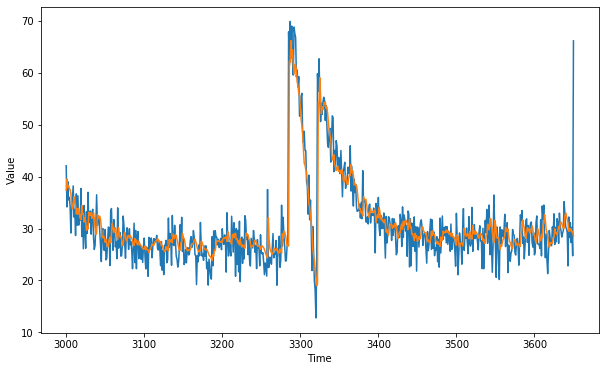

In [10]:
forecast = []
results = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [11]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

2.920535

<Figure size 432x288 with 0 Axes>

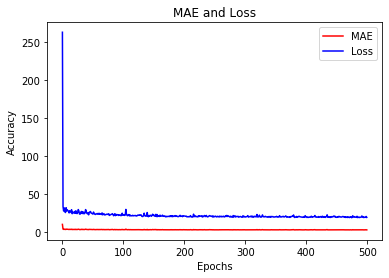

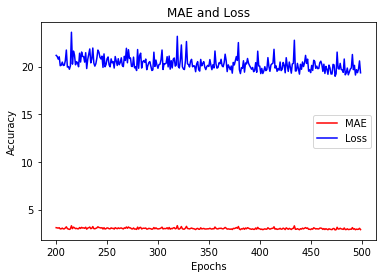

<Figure size 432x288 with 0 Axes>

In [12]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()